In [1]:
import pandas as pd
import numpy as np
import json
import os
import random
import string
import re
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_squared_log_error

pd.set_option('display.max_columns', 500)


In [2]:

df_train = pd.read_pickle('../data/train/full_comp.pickle')
df_test = pd.read_pickle('../data/test/full.pickle')


In [3]:
df_train.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date_x,authors_parsed,doi_cites,cites,doi_id,pub_publisher,pub_journals,pub_dois,update_date_y,first_created_date,last_created_date,update_year,first_created_year,last_created_year,update_month,first_created_month,last_created_month,update_ym,first_created_ym,last_created_ym,update_day,first_created_day,last_created_day,update_date_unixtime,first_created_unixtime,last_created_unixtime,diff_update_date_unixtime,diff_created_unixtime,num_created,update_date_days,first_created_days,last_created_days,diff_created_days,author_first,author_num,astro-ph.co,astro-ph.ep,astro-ph.ga,astro-ph.he,astro-ph.im,astro-ph.sr,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.other,cond-mat.quant-gas,cond-mat.soft,cond-mat.stat-mech,cond-mat.str-el,cond-mat.supr-con,cs.ai,cs.ar,cs.cc,cs.ce,cs.cg,cs.cl,cs.cr,cs.cv,cs.cy,cs.db,cs.dc,cs.dl,cs.dm,cs.ds,cs.et,cs.fl,cs.gl,cs.gr,cs.gt,cs.hc,cs.ir,cs.it,cs.lg,cs.lo,cs.ma,cs.mm,cs.ms,cs.na,cs.ne,cs.ni,cs.oh,cs.os,cs.pf,cs.pl,cs.ro,cs.sc,cs.sd,cs.se,cs.si,cs.sy,econ.em,econ.gn,econ.th,eess.as,eess.iv,eess.sp,eess.sy,math.ac,math.ag,math.ap,math.at,math.ca,math.co,math.ct,math.cv,math.dg,math.ds,math.fa,math.gm,math.gn,math.gr,math.gt,math.ho,math.it,math.kt,math.lo,math.mg,math.mp,math.na,math.nt,math.oa,math.oc,math.pr,math.qa,math.ra,math.rt,math.sg,math.sp,math.st,nlin.ao,nlin.cd,nlin.cg,nlin.ps,nlin.si,physics.acc-ph,physics.ao-ph,physics.app-ph,physics.atm-clus,physics.atom-ph,physics.bio-ph,physics.chem-ph,physics.class-ph,physics.comp-ph,physics.data-an,physics.ed-ph,physics.flu-dyn,physics.gen-ph,physics.geo-ph,physics.hist-ph,physics.ins-det,physics.med-ph,physics.optics,physics.plasm-ph,physics.pop-ph,physics.soc-ph,physics.space-ph,q-bio.bm,q-bio.cb,q-bio.gn,q-bio.mn,q-bio.nc,q-bio.ot,q-bio.pe,q-bio.qm,q-bio.sc,q-bio.to,q-fin.cp,q-fin.ec,q-fin.gn,q-fin.mf,q-fin.pm,q-fin.pr,q-fin.rm,q-fin.st,q-fin.tr,stat.ap,stat.co,stat.me,stat.ml,stat.ot,stat.th,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,atom-ph,bayes-an,chao-dyn,chem-ph,cmp-lg,comp-gas,cond-mat,dg-ga,funct-an,gr-qc,hep-ex,hep-lat,hep-ph,hep-th,math-ph,mtrl-th,nucl-ex,nucl-th,patt-sol,plasm-ph,q-alg,q-bio,q-fin,quant-ph,solv-int,supr-con,acc,adap,alg,ao,astro,atom,bayes,chao,chem,cmp,comp,cond,cs,dg,econ,eess,funct,gr,hep,math,mtrl,nlin,nucl,patt,physics,plasm,q,quant,solv,stat,supr,submitter_label,doi_id_label,author_first_label,pub_publisher_label,doi_cites_mean_author_first_label,doi_cites_count_author_first_label,doi_cites_sum_author_first_label,doi_cites_min_author_first_label,doi_cites_max_author_first_label,doi_cites_median_author_first_label,doi_cites_std_author_first_label,doi_cites_q10_author_first_label,doi_cites_q25_author_first_label,doi_cites_q75_author_first_label,doi_cites_mean_doi_id_label,doi_cites_count_doi_id_label,doi_cites_sum_doi_id_label,doi_cites_min_doi_id_label,doi_cites_max_doi_id_label,doi_cites_median_doi_id_label,doi_cites_std_doi_id_label,doi_cites_q10_doi_id_label,doi_cites_q25_doi_id_label,doi_cites_q75_doi_id_label,doi_cites_mean_pub_publisher_label,doi_cites_count_pub_publisher_label,doi_cites_sum_pub_publisher_label,doi_cites_min_pub_publisher_label,doi_cites_max_pub_publisher_label,doi_cites_median_pub_publisher_label,doi_cites_std_pub_publisher_label,doi_cites_q10_pub_publisher_label,doi_cites_q25_pub_publisher_label,doi_cites_q75_pub_publisher_label,doi_cites_mean_submitter_label,doi_cites_count_submitter_label,doi_cites_sum_submitter_label,doi_cites_min_submitter_label,doi_cites_max_submitter_label,doi_cites_median_submitter_label,doi_cites_std_submitter_label,doi_cites_q10_submitter_label,doi_cites_q25_submitter_label,doi_cites_q75_submitter_label,doi_cites_mean_update_ym,doi_cites_count_update_ym,doi_cites_sum_update_ym,doi_cites_min_update_ym,doi_cites_max_update_ym,doi_cites_median_update_ym,doi_cites_std_update_ym,doi_cites_q10_update_ym,doi_cites_q25_update_ym,doi_cites_q75_update_

In [4]:
df_train = df_train[df_train['cites'] >= 1].reset_index(drop=True)
df_train.shape

(15117, 319)

In [5]:
df_train.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date_x,authors_parsed,doi_cites,cites,doi_id,pub_publisher,pub_journals,pub_dois,update_date_y,first_created_date,last_created_date,update_year,first_created_year,last_created_year,update_month,first_created_month,last_created_month,update_ym,first_created_ym,last_created_ym,update_day,first_created_day,last_created_day,update_date_unixtime,first_created_unixtime,last_created_unixtime,diff_update_date_unixtime,diff_created_unixtime,num_created,update_date_days,first_created_days,last_created_days,diff_created_days,author_first,author_num,astro-ph.co,astro-ph.ep,astro-ph.ga,astro-ph.he,astro-ph.im,astro-ph.sr,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.other,cond-mat.quant-gas,cond-mat.soft,cond-mat.stat-mech,cond-mat.str-el,cond-mat.supr-con,cs.ai,cs.ar,cs.cc,cs.ce,cs.cg,cs.cl,cs.cr,cs.cv,cs.cy,cs.db,cs.dc,cs.dl,cs.dm,cs.ds,cs.et,cs.fl,cs.gl,cs.gr,cs.gt,cs.hc,cs.ir,cs.it,cs.lg,cs.lo,cs.ma,cs.mm,cs.ms,cs.na,cs.ne,cs.ni,cs.oh,cs.os,cs.pf,cs.pl,cs.ro,cs.sc,cs.sd,cs.se,cs.si,cs.sy,econ.em,econ.gn,econ.th,eess.as,eess.iv,eess.sp,eess.sy,math.ac,math.ag,math.ap,math.at,math.ca,math.co,math.ct,math.cv,math.dg,math.ds,math.fa,math.gm,math.gn,math.gr,math.gt,math.ho,math.it,math.kt,math.lo,math.mg,math.mp,math.na,math.nt,math.oa,math.oc,math.pr,math.qa,math.ra,math.rt,math.sg,math.sp,math.st,nlin.ao,nlin.cd,nlin.cg,nlin.ps,nlin.si,physics.acc-ph,physics.ao-ph,physics.app-ph,physics.atm-clus,physics.atom-ph,physics.bio-ph,physics.chem-ph,physics.class-ph,physics.comp-ph,physics.data-an,physics.ed-ph,physics.flu-dyn,physics.gen-ph,physics.geo-ph,physics.hist-ph,physics.ins-det,physics.med-ph,physics.optics,physics.plasm-ph,physics.pop-ph,physics.soc-ph,physics.space-ph,q-bio.bm,q-bio.cb,q-bio.gn,q-bio.mn,q-bio.nc,q-bio.ot,q-bio.pe,q-bio.qm,q-bio.sc,q-bio.to,q-fin.cp,q-fin.ec,q-fin.gn,q-fin.mf,q-fin.pm,q-fin.pr,q-fin.rm,q-fin.st,q-fin.tr,stat.ap,stat.co,stat.me,stat.ml,stat.ot,stat.th,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,atom-ph,bayes-an,chao-dyn,chem-ph,cmp-lg,comp-gas,cond-mat,dg-ga,funct-an,gr-qc,hep-ex,hep-lat,hep-ph,hep-th,math-ph,mtrl-th,nucl-ex,nucl-th,patt-sol,plasm-ph,q-alg,q-bio,q-fin,quant-ph,solv-int,supr-con,acc,adap,alg,ao,astro,atom,bayes,chao,chem,cmp,comp,cond,cs,dg,econ,eess,funct,gr,hep,math,mtrl,nlin,nucl,patt,physics,plasm,q,quant,solv,stat,supr,submitter_label,doi_id_label,author_first_label,pub_publisher_label,doi_cites_mean_author_first_label,doi_cites_count_author_first_label,doi_cites_sum_author_first_label,doi_cites_min_author_first_label,doi_cites_max_author_first_label,doi_cites_median_author_first_label,doi_cites_std_author_first_label,doi_cites_q10_author_first_label,doi_cites_q25_author_first_label,doi_cites_q75_author_first_label,doi_cites_mean_doi_id_label,doi_cites_count_doi_id_label,doi_cites_sum_doi_id_label,doi_cites_min_doi_id_label,doi_cites_max_doi_id_label,doi_cites_median_doi_id_label,doi_cites_std_doi_id_label,doi_cites_q10_doi_id_label,doi_cites_q25_doi_id_label,doi_cites_q75_doi_id_label,doi_cites_mean_pub_publisher_label,doi_cites_count_pub_publisher_label,doi_cites_sum_pub_publisher_label,doi_cites_min_pub_publisher_label,doi_cites_max_pub_publisher_label,doi_cites_median_pub_publisher_label,doi_cites_std_pub_publisher_label,doi_cites_q10_pub_publisher_label,doi_cites_q25_pub_publisher_label,doi_cites_q75_pub_publisher_label,doi_cites_mean_submitter_label,doi_cites_count_submitter_label,doi_cites_sum_submitter_label,doi_cites_min_submitter_label,doi_cites_max_submitter_label,doi_cites_median_submitter_label,doi_cites_std_submitter_label,doi_cites_q10_submitter_label,doi_cites_q25_submitter_label,doi_cites_q75_submitter_label,doi_cites_mean_update_ym,doi_cites_count_update_ym,doi_cites_sum_update_ym,doi_cites_min_update_ym,doi_cites_max_update_ym,doi_cites_median_update_ym,doi_cites_std_update_ym,doi_cites_q10_update_ym,doi_cites_q25_update_ym,doi_cites_q75_update_

In [6]:
target = np.array(np.log1p(df_train['cites'].values))
len(target), target

(15117,
 array([2.07944154, 5.24174702, 2.19722458, ..., 4.58496748, 1.60943791,
        1.38629436]))

In [7]:
#####################################################
### LGBで学習、予測する関数の定義
#####################################################
from sklearn.preprocessing import LabelEncoder

SEED = 777
NFOLDS = 5
def Train_and_Pred(df_train, target, test):
    # --------------------------------------
    # パラメータ定義
    # --------------------------------------
    lgb_params = {
                    'objective': 'root_mean_squared_error',
                    'boosting_type': 'gbdt',
                    'n_estimators': 50000,
                    'colsample_bytree': 0.8,
                    'subsample': 0.8,
                    'learning_rate': 0.01,
                  }

    # train
    train = df_train.copy()
    train['doi_cites'] = train['doi_cites'].astype('int')
    train = train.drop(['id', 'authors', 'title', 'comments',
        'journal-ref', 'doi', 'report-no', 'categories', 'license',
        'abstract', 'versions', 'update_date_x', 'authors_parsed', 'pub_publisher',
        'update_date_y', 'first_created_date', 'last_created_date', 'cites', 'doi_id', 'submitter', 'author_first']
        , axis=1
    )

    
    kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
    lgb_oof = np.zeros(train.shape[0])
    lgb_pred = 0


    for fold, (trn_idx, val_idx) in enumerate(kf.split(train)):
        X_train, y_train = train.iloc[trn_idx], target[trn_idx]
        X_valid, y_valid = train.iloc[val_idx], target[val_idx]

        # LightGBM
        model = lgb.LGBMRegressor(**lgb_params)
        model.fit(X_train, y_train,
                  eval_set=(X_valid, y_valid),
                  eval_metric='mse',
                  verbose=False,
                  early_stopping_rounds=50,
                  categorical_feature=['submitter_label', 'doi_id_label', 'author_first_label', 'pub_publisher_label', 'license_label']
        )

        lgb_oof[val_idx] = model.predict(X_valid)
        rmsle = mean_squared_error(y_valid, lgb_oof[val_idx], squared=False)
        print(f"fold {fold} lgb score: {rmsle}")

    rmsle = mean_squared_error(target, lgb_oof, squared=False)
    print("+-" * 40)
    print(f"score: {rmsle}")
    print(f"model score: {model.score(train, target)}")

    # ------------------------------------------------------------------------------
    # 提出ファイルの作成
    # ------------------------------------------------------------------------------
    #test_predicted = np.expm1(lgb_pred)

    #submit_df = pd.DataFrame({'id': test_index})
    #submit_df['cites'] = np.where(test_predicted < 0, 0, test_predicted)
    #submit_df.to_csv("submission.csv", index=False)
    return model

In [8]:
model = Train_and_Pred(df_train,target,df_test)

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['author_first_label', 'doi_id_label', 'pub_publisher_label', 'submitter_label']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
fold 0 lgb score: 0.4900771547395697
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dat

In [16]:
model = Train_and_Pred(df_train,target,df_test)

fold 0 lgb score: 0.4917295584288038
fold 1 lgb score: 0.5178155373895361
fold 2 lgb score: 0.49957067643936737
fold 3 lgb score: 0.5013030936620012
fold 4 lgb score: 0.5068572602380822
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
score: 0.5035298929821963
model score: 0.8656471882788919


In [ ]:
score: 0.5039884407388852

In [20]:
df_feature.head(50)

,importance
doi_cites,454105.468546
diff_rate_doi_cites_doi_cites_mean_pub_publisher_label,99640.545068
diff_doi_cites_doi_cites_mean_update_ym,59322.885870
diff_rate_doi_cites_doi_cites_mean_doi_id_label,18189.672483
diff_doi_cites_doi_cites_mean_doi_id_label,12524.836552
math,8703.833246
diff_rate_doi_cites_doi_cites_mean_update_ym,7540.238640
diff_doi_cites_doi_cites_mean_pub_publisher_label,6045.700070
cs,5328.429489
last_created_unixtime,4993.913177


<AxesSubplot:>

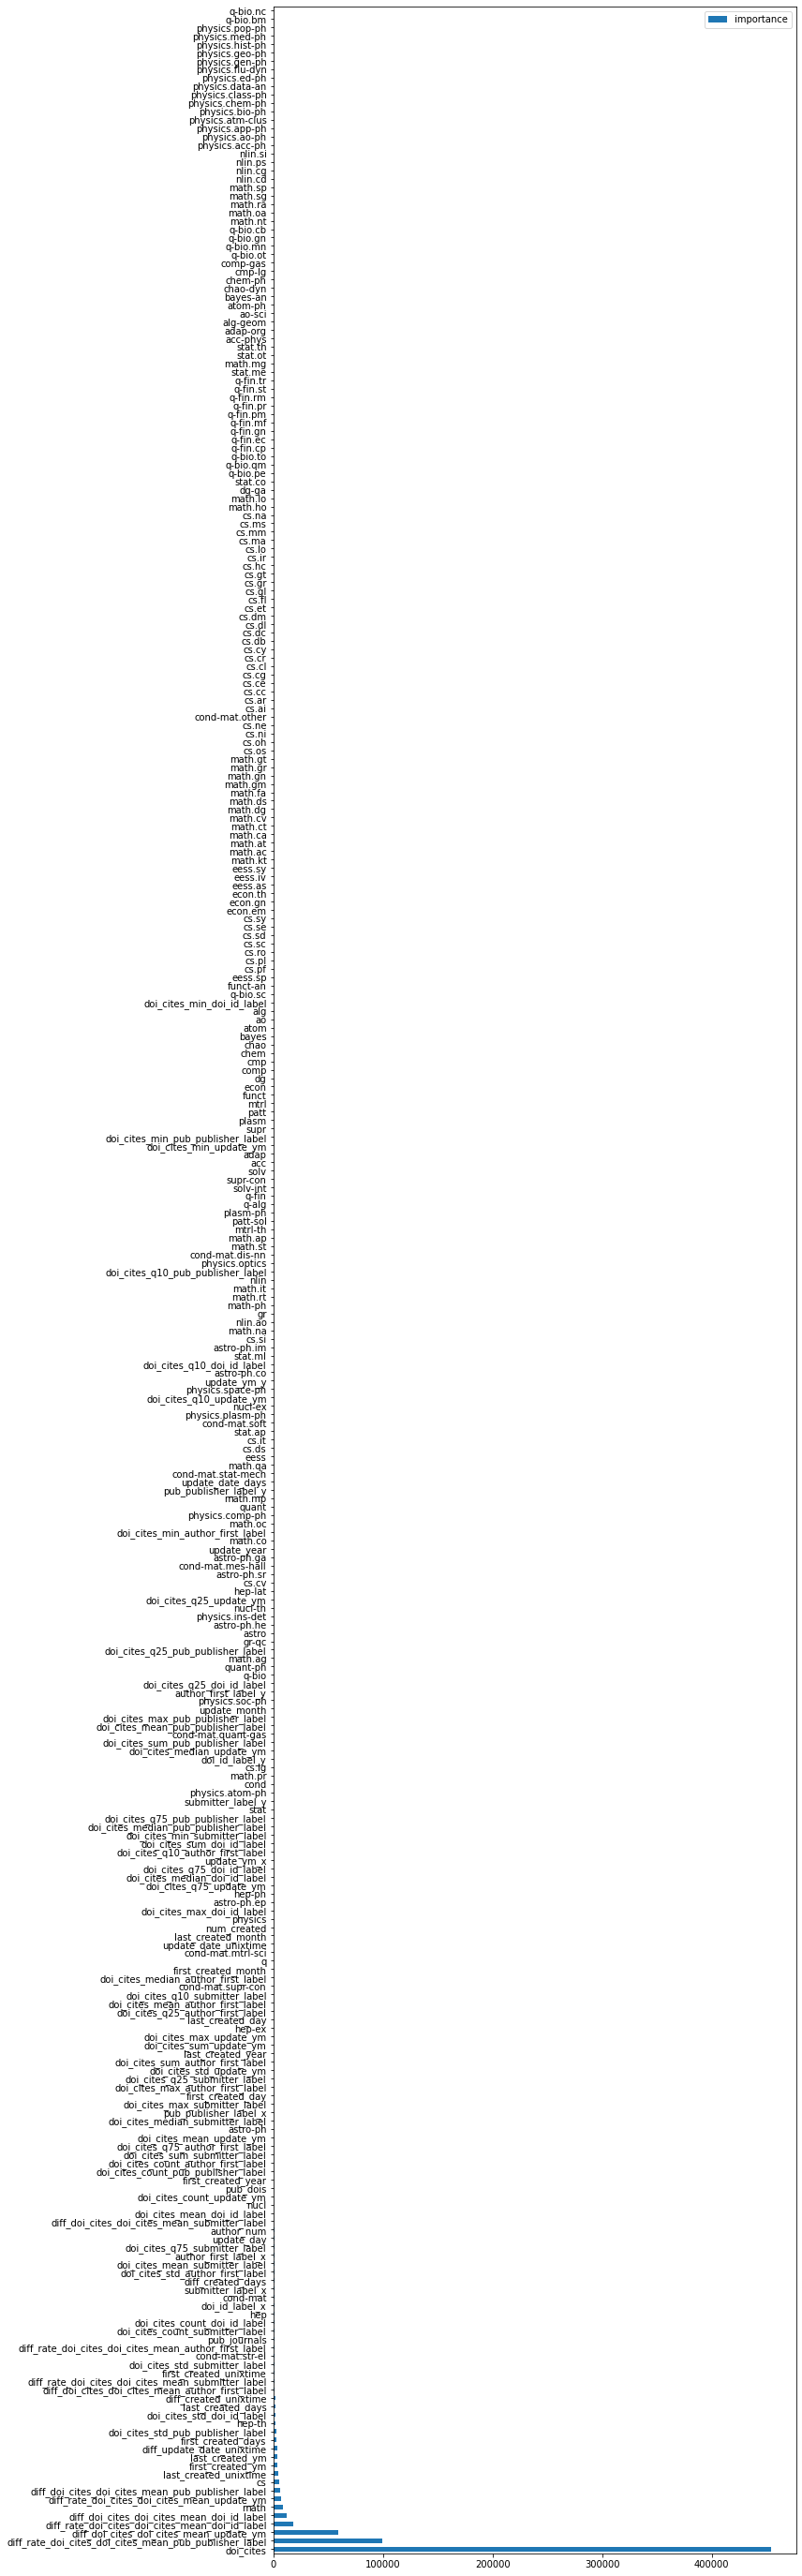

In [17]:
feature = df_train.copy()
feature['doi_cites'] = feature['doi_cites'].astype('int')
feature = feature.drop(['id', 'authors', 'title', 'comments',
    'journal-ref', 'doi', 'report-no', 'categories', 'license',
    'abstract', 'versions', 'update_date_x', 'authors_parsed', 'pub_publisher',
    'update_date_y', 'first_created_date', 'last_created_date', 'cites', 'doi_id', 'submitter', 'author_first']
    , axis=1
)
df_feature = pd.DataFrame(model.booster_.feature_importance(importance_type='gain'), index=feature.columns, columns=['importance']).sort_values('importance', ascending=False)
df_feature.plot.barh(figsize=(10,50))


In [30]:
pd.DataFrame(model.feature_importance_, index=df_train.feature_names[:-1], columns=['importance'])

AttributeError: 'LGBMRegressor' object has no attribute 'feature_importance_'